## 3. 多层感知机

深度学习主要关注多层模型,前面的线性回归和softmax回归都是单层神经网络.多层感知机（multilayer perceptron，MLP）就是是多层神经网络。

### 3.1 隐藏层
多层感知机在单层神经网络的基础上引入了一到多个隐藏层（hidden layer）。隐藏层位于输入层和输出层之间。图展示了一个多层感知机的神经网络图，它含有一个隐藏层，该层中有5个隐藏单元。输入层不涉及运算,该图的多层感知机层数为2,隐藏层和输出层都是全连接层.
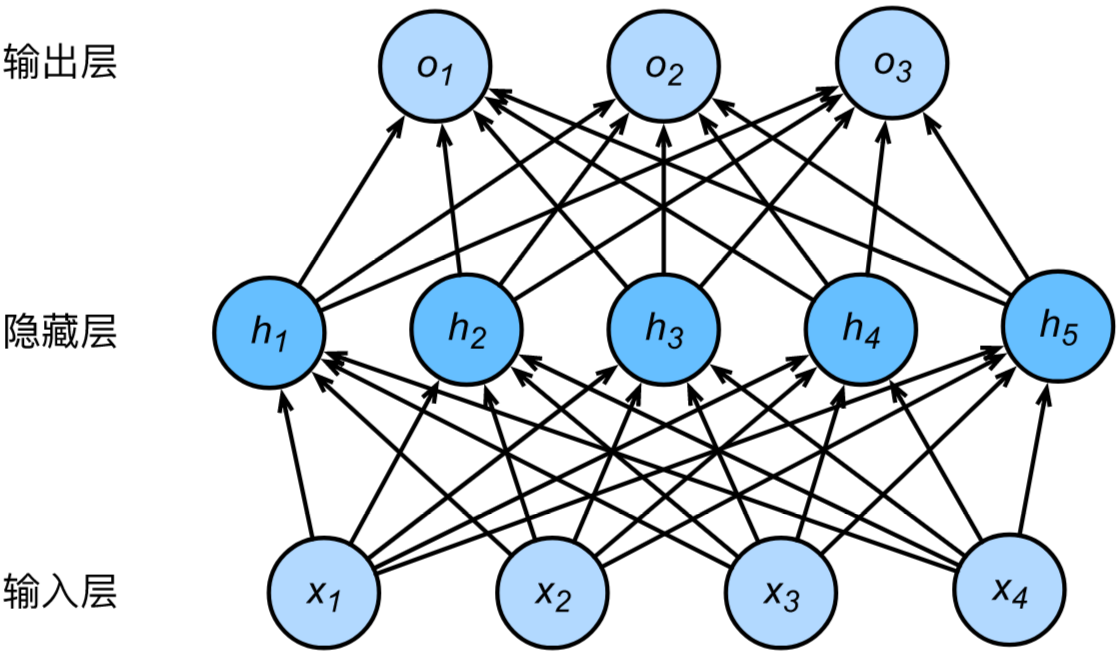

### 3.2 激活函数
使用激活函数对上层输入的数据进行非线性变换,然后作为下一全连接层的输入,常见的激活函数有如下几种:

- ReLU 函数
ReLU（rectified linear unit）函数提供了一个很简单的非线性变换。给定元素 x ，该函数定义为:
    
$$ \text{ReLU}(x) = \max(x, 0) $$

显然ReLU函数只保留正数元素，并将负数元素清零.

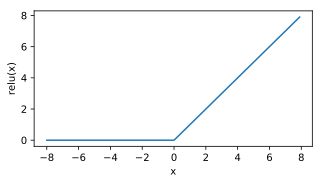

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')
    
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
#绘制ReLU函数
xyplot(x, y, 'relu')

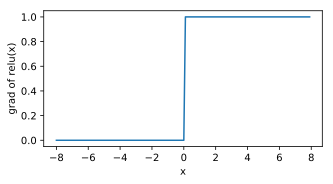

In [2]:
#绘制ReLU函数的导数
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

- sigmoid函数
sigmoid函数可以将元素的值变换到0和1之间：
$$ \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)} $$

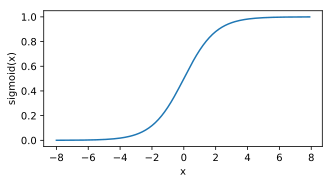

In [3]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

依据链式法则，sigmoid函数的导数
$$\text{sigmoid}'(x) = \text{sigmoid}(x)\left(1-\text{sigmoid}(x)\right).$$

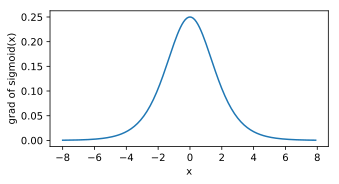

In [4]:
x.grad.zero_()#求导之前先清零
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

- tanh函数

tanh（双曲正切）函数可以将元素的值变换到-1和1之间：
$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$
绘制tanh函数。当输入接近0时，tanh函数接近线性变换。虽然该函数的形状和sigmoid函数的形状很像，但tanh函数在坐标系的原点上对称。

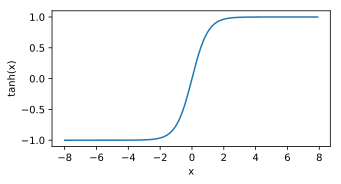

In [5]:
y = x.tanh()
xyplot(x, y, 'tanh')

依据链式法则，tanh函数的导数

$$\text{tanh}'(x) = 1 - \text{tanh}^2(x).$$
 
下面绘制了tanh函数的导数。当输入为0时，tanh函数的导数达到最大值1；当输入越偏离0时，tanh函数的导数越接近0。

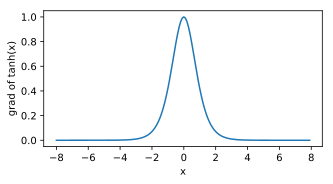

In [6]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

**关于激活函数的选择**

ReLu函数是一个通用的激活函数，目前在大多数情况下使用。但是，ReLU函数只能在隐藏层中使用。

用于分类器时，sigmoid函数及其组合通常效果更好。由于梯度消失问题，有时要避免使用sigmoid和tanh函数。

在神经网络层数较多的时候，最好使用ReLu函数，ReLu函数比较简单计算量少，而sigmoid和tanh函数计算量大很多。

在选择激活函数的时候可以先选用ReLu函数如果效果不理想可以尝试其他激活函数。

**总结以上**多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换。多层感知机的层数和各隐藏层中隐藏单元个数都是超参数。以单隐藏层为例并沿用本节之前定义的符号，多层感知机按以下方式计算输出：

$$\begin{aligned} \boldsymbol{H} &= \phi(\boldsymbol{X} \boldsymbol{W}_h + \boldsymbol{b}_h),\\ \boldsymbol{O} &= \boldsymbol{H} \boldsymbol{W}_o + \boldsymbol{b}_o, \end{aligned}$$

 
其中 $\phi $ 表示激活函数。

### 3.3 多层感知机从零开始实现
读取数据

In [7]:
import torch
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

定义模型参数

因为Fashion-MNIST数据集中图像形状为28\*28, 类别为10. 所以我们使用28\*28=784的向量表示每一张图像,

因此,输入个数为784,输出个数为10.隐藏单元个数为256个

In [11]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [12]:
#定义激活函数
def relu(X):
    #torch.max将逐个元素比较张量input与张量other，将比较出的最大值保存到输出张量中。
    return torch.max(input=X, other=torch.tensor(0.0))

#定义模型
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

#定义损失函数
#直接使用PyTorch提供的包括softmax运算和交叉熵损失计算的函数
loss = torch.nn.CrossEntropyLoss()

训练模型

In [13]:
#训练多层感知机的步骤和3.6节中训练softmax回归的步骤没什么区别
#直接调用d2lzh_pytorch包中的train_ch3函数
num_epochs, lr = 5, 100.0
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0031, train acc 0.711, test acc 0.791
epoch 2, loss 0.0019, train acc 0.823, test acc 0.780
epoch 3, loss 0.0017, train acc 0.842, test acc 0.829
epoch 4, loss 0.0015, train acc 0.855, test acc 0.831
epoch 5, loss 0.0015, train acc 0.862, test acc 0.855


### 3.4 多层感知机简洁实现

In [14]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

#定义模型
num_inputs, num_outputs, num_hiddens = 784, 10, 256
net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs)
        )
for param in net.parameters():
    init.normal_(param, mean=0, std=0.01)

In [15]:
#读取数据并训练模型
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0032, train acc 0.700, test acc 0.770
epoch 2, loss 0.0019, train acc 0.822, test acc 0.814
epoch 3, loss 0.0016, train acc 0.844, test acc 0.819
epoch 4, loss 0.0015, train acc 0.855, test acc 0.793
epoch 5, loss 0.0015, train acc 0.861, test acc 0.856


### 3.5 课后作业

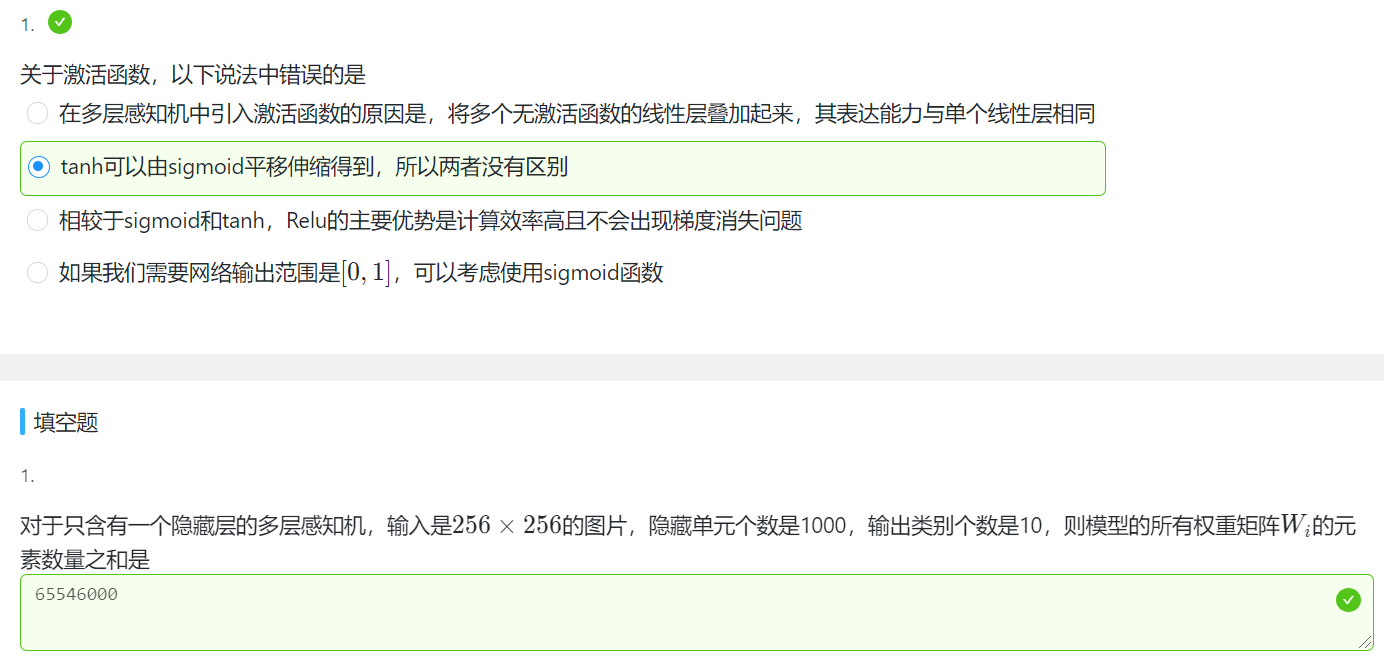